# Installations and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict

from sklearn.compose import make_column_selector, ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder


Mounted at /content/drive


In [2]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190292 sha256=4f44f789f6e67e702e076e1501f3cb3bcfdd4a195a5e42364f1c4e48a6e28623
  Stored in directory: /root/.cache/pip/wheels/81/1b/61/aa85b78c3c0c8871f4231e3f4a03bb23cecb7db829498380ee
Successfully built pyod


# Data

**Data Cleanup**

In [3]:
# Merge datasets from team together
data1 = pd.read_csv("/content/drive/Shareddrives/CS 229 Final Project/CS 229 Project/final_dataset_1.csv")
print(data1.shape)
print(data1.columns)
data2 = pd.read_csv("/content/drive/Shareddrives/CS 229 Final Project/CS 229 Project/final_dataset_2.csv")
data2.drop(['Unnamed: 0.1'], axis=1, inplace=True)
print(data2.shape)
print(data2.columns)
data3 = pd.read_csv("/content/drive/Shareddrives/CS 229 Final Project/CS 229 Project/final_dataset_3.csv")
data3.drop(['Unnamed: 0.1'], axis=1, inplace=True)
print(data3.shape)
print(data3.columns)
data4 = pd.read_csv("/content/drive/Shareddrives/CS 229 Final Project/CS 229 Project/compiled_dataset.csv")
print(data4.shape)
print(data4.columns)
data = pd.concat([data1, data2, data3, data4], ignore_index=True)
print(data.shape)
print(data.columns)
data.drop(['Unnamed: 0'],  axis=1, inplace=True)
print(data.shape)
print(data.columns)

(50000, 20)
Index(['Unnamed: 0', 'start_date', 'FIRE_SIZE_CLASS', 'category', 'cause',
       'size', 'lat', 'lon', 'buinfdr', 'ercnfdr', 'icnfdr', 'scnfdr', 'u10',
       'v10', 't2m', 'blh', 'cape', 'lai_hv', 'lai_lv', 'slt'],
      dtype='object')
(50000, 20)
Index(['Unnamed: 0', 'start_date', 'FIRE_SIZE_CLASS', 'category', 'cause',
       'size', 'lat', 'lon', 'buinfdr', 'ercnfdr', 'icnfdr', 'scnfdr', 'u10',
       'v10', 't2m', 'blh', 'cape', 'lai_hv', 'lai_lv', 'slt'],
      dtype='object')
(50000, 20)
Index(['Unnamed: 0', 'start_date', 'FIRE_SIZE_CLASS', 'category', 'cause',
       'size', 'lat', 'lon', 'buinfdr', 'ercnfdr', 'icnfdr', 'scnfdr', 'u10',
       'v10', 't2m', 'blh', 'cape', 'lai_hv', 'lai_lv', 'slt'],
      dtype='object')
(10000, 20)
Index(['Unnamed: 0', 'start_date', 'FIRE_SIZE_CLASS', 'category', 'cause',
       'size', 'lat', 'lon', 'buinfdr', 'ercnfdr', 'icnfdr', 'scnfdr', 'u10',
       'v10', 't2m', 'blh', 'cape', 'lai_hv', 'lai_lv', 'slt'],
      dtype='objec

In [4]:
# Remove any duplicate rows
data.drop_duplicates(inplace=True)
# Temporarily removing Emma's features
#data.drop(['Unnamed: 0', 'start_date', 'u10', 'v10', 't2m', 'blh', 'cape', 'lai_hv', 'lai_lv', 'slt', 'FIRE_SIZE_CLASS'],  axis=1, inplace=True)
# Remove any rows that have empty values
data.dropna(inplace=True)
# Full Features
data.drop(['FIRE_SIZE_CLASS', 'start_date'],  axis=1, inplace=True)
# Picked Features
# data.drop(['FIRE_SIZE_CLASS', 'start_date', 'cause', 'slt',
#            'category', 'lai_hv', 'scnfdr', 'buinfdr', 'icnfdr', 'cape',
#            'ercnfdr', 'blh'],  axis=1, inplace=True)
num_empty_vals = data[data.isna().any(axis=1)]
print("Num Empty Values: {}".format(num_empty_vals.shape[0]))
print("Shape of Clean Data: {}".format(data.shape))
#data_filtered.to_csv('final_data.csv', index = False) # visually make sure things look good
print("Feature Data Types:")
print((data.dtypes))

Num Empty Values: 0
Shape of Clean Data: (98510, 17)
Feature Data Types:
category     object
cause        object
size        float64
lat         float64
lon         float64
buinfdr     float64
ercnfdr     float64
icnfdr      float64
scnfdr      float64
u10         float64
v10         float64
t2m         float64
blh         float64
cape        float64
lai_hv      float64
lai_lv      float64
slt         float64
dtype: object


**Separate Features and Target**

In [5]:
# Define input features and labels
target_name = "size"
y = data[target_name] # vector of labels [size of the fire in acres]
X = data.drop(columns=[target_name]) # input features
print(X.shape)
print(y.shape)

(98510, 16)
(98510,)


**Remove Outliers**

In [6]:
# Import MAD estimator
from pyod.models.mad import MAD

# Set threshold to 3
mad = MAD(threshold = 4)

# Convert the 'total' column into a 2D numpy array
total_reshaped = data['size'].values.reshape(-1, 1)

# Generate inline and outlier labels
labels = mad.fit(total_reshaped).labels_
labels
print(f'Number of outliers: {labels.sum()}')
filter = data[labels == 0]
filter.head()

Number of outliers: 16524


,category,cause,size,lat,lon,buinfdr,ercnfdr,icnfdr,scnfdr,u10,v10,t2m,blh,cape,lai_hv,lai_lv,slt
0,Human,Missing data/not specified/undetermined,0.1,32.194444,-110.871319,18.0,17.0,18.0,3.0,1.724119,-2.655896,291.417908,647.081116,7.96875,0.0,0.0,0.0
1,Human,Smoking,2.0,35.198300,-78.975000,24.0,31.0,8.0,3.0,3.165710,6.769073,292.052643,1011.800537,0.56250,0.0,0.0,0.0
2,Missing data/not specified/undetermined,Missing data/not specified/undetermined,0.5,41.828400,-73.016210,0.0,0.0,0.0,0.0,-6.648168,2.669733,276.334839,694.782593,3.68750,0.0,0.0,0.0
3,Human,Debris and open burning,1.0,36.856593,-91.957396,0.0,8.0,0.0,0.0,6.886183,12.232545,294.571106,995.984924,962.25000,0.0,0.0,0.0
4,Human,Debris and open burning,0.1,37.481580,-95.105738,7.0,6.0,7.0,1.0,0.666777,-4.233582,297.963135,520.046143,35.00000,0.0,0.0,0.0


**Update Data to Remove Outliers**

In [7]:
data = filter

**Data Visualization**

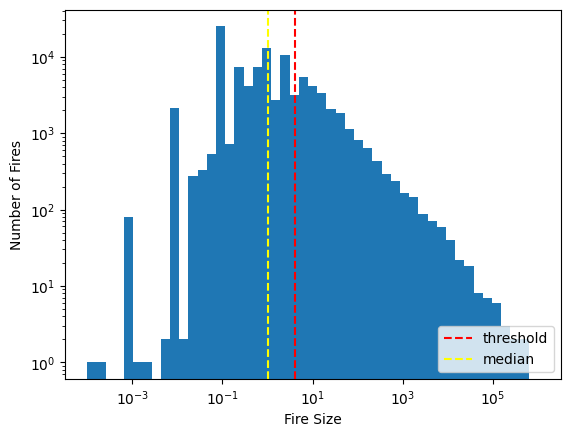

Skewness: 117.08974487571282
Mean fire size: 77.75635167318039
Median fire size: 1.0
Var in fire size: 10570359.769925943


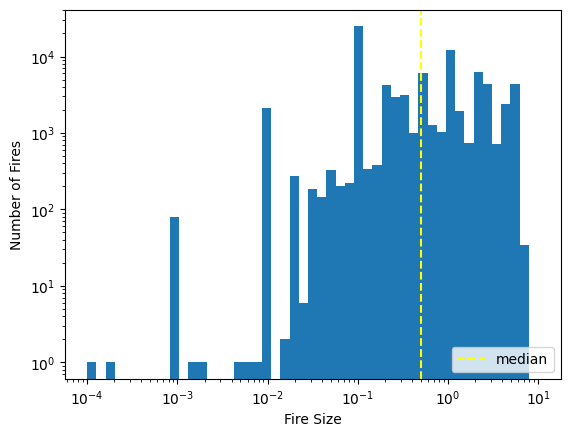

Skewness: 1.7900760048354547
Mean fire size: 1.0744647960017566
Median fire size: 0.5
Var in fire size: 2.0188738614275836


In [8]:
from scipy.stats import skew
# Distibution of fire size with outliers
plt.hist(y, bins=np.logspace(-4,6, 50));
plt.ylabel('Number of Fires')
plt.xlabel('Fire Size')
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.axvline( mad.fit(total_reshaped).threshold_, linestyle="dashed", color="red")
plt.axvline(np.median(y), linestyle="dashed", color="yellow")
plt.legend(["threshold", "median"], loc ="lower right")
plt.show()

print("Skewness: {}".format(skew(y)))
print("Mean fire size: {}".format(np.mean(y)))
print("Median fire size: {}".format(np.median(y)))
print("Var in fire size: {}".format(np.var(y)))

#Distibution of fire size without Outliers
y_1 = filter['size'].values
plt.hist(y_1, bins=np.logspace(-4,1, 50));
plt.ylabel('Number of Fires')
plt.xlabel('Fire Size')
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.axvline(np.median(y_1), linestyle="dashed", color="yellow")
plt.legend(["median"], loc ="lower right")
plt.show()

print("Skewness: {}".format(skew(y_1)))
print("Mean fire size: {}".format(np.mean(y_1)))
print("Median fire size: {}".format(np.median(y_1)))
print("Var in fire size: {}".format(np.var(y_1)))

**Visualize on Map**

In [9]:
import plotly.graph_objects as go
df = copy.deepcopy(data.sample(frac=.03))
df['text'] = 'Category: ' + df['category'] + ', '  + 'Cause: '+ df['cause'] + ', ' + 'Size: ' + df['size'].astype(str)

fig = go.Figure(data=go.Scattergeo(
        lon = df['lon'],
        lat = df['lat'],
        text = df['text'],
        mode = 'markers',
        marker_color = df['size'],
        marker_coloraxis="coloraxis"
        ))

fig.update_layout(
        title = 'Wildfires without Outliers<br>(Scale is in Acres)',
        geo_scope='usa',
        showlegend=False,
        autosize=False,
        width=800,
        height=800,
    )

fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)
fig.show()

In [10]:
# Keep most important features
#data.drop(['cause', 'slt',
           #'category', 'lai_hv', 'lai_lv', 'scnfdr', 'buinfdr', 'icnfdr', 'u10',
           #'ercnfdr'],  axis=1, inplace=True)
#print(data.shape)
#print(data.columns)

# Define input features and labels
target_name = "size"
y = data[target_name] # vector of labels [size of the fire in acres]
X = data.drop(columns=[target_name]) # input features
print(X.shape)
print(y.shape)

(81986, 16)
(81986,)


# Linear Regression

**Model**

In [11]:
from sklearn.linear_model import LinearRegression
# selection of columns based on data types
numerical_columns_selector = make_column_selector(dtype_exclude=object)
categorical_columns_selector = make_column_selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

# one-hot encoding is applied to categorical columns, and numerical features
# are standardized
categorical_preprocessor = OneHotEncoder()
numerical_preprocessor = StandardScaler()

# use a transformer to concatenate the new columns
preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
        ("standard_scaler", numerical_preprocessor, numerical_columns),
    ]
)

lin_reg_model = make_pipeline(preprocessor, LinearRegression())
scoring = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error", "r2"]
n_cv_folds = 5
model_result = cross_validate(lin_reg_model, X, y, cv = n_cv_folds, scoring=scoring, return_train_score=True)
y_pred = cross_val_predict(lin_reg_model, X, y, cv=n_cv_folds)

**Prediction Visualization**

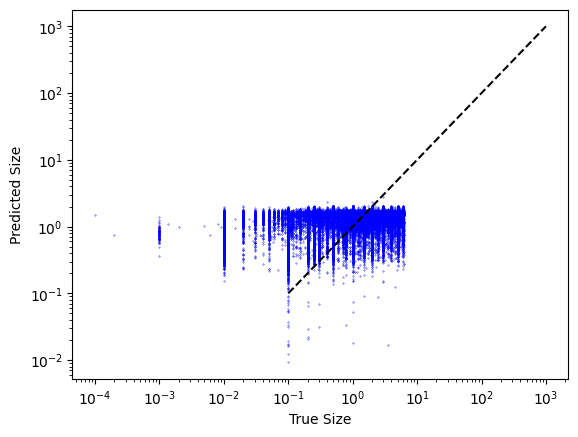

In [12]:
plt.scatter(y, y_pred, s=0.3, marker='.', c='b')
plt.xlabel('True Size')
plt.ylabel('Predicted Size')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.plot([.1,20,1000],[.1,20,1000],c='k',linestyle='--')
plt.show()

**Error Visualization**

fit_time: 0.3584264278411865
score_time: 0.05815348625183105
test_neg_mean_absolute_error: 0.9918196719375902
train_neg_mean_absolute_error: 0.9909662003900171
test_neg_mean_absolute_percentage_error: 6.868983402901577
train_neg_mean_absolute_percentage_error: 6.836367050934236
test_r2: 0.07885474084043853
train_r2: 0.08052404263722837


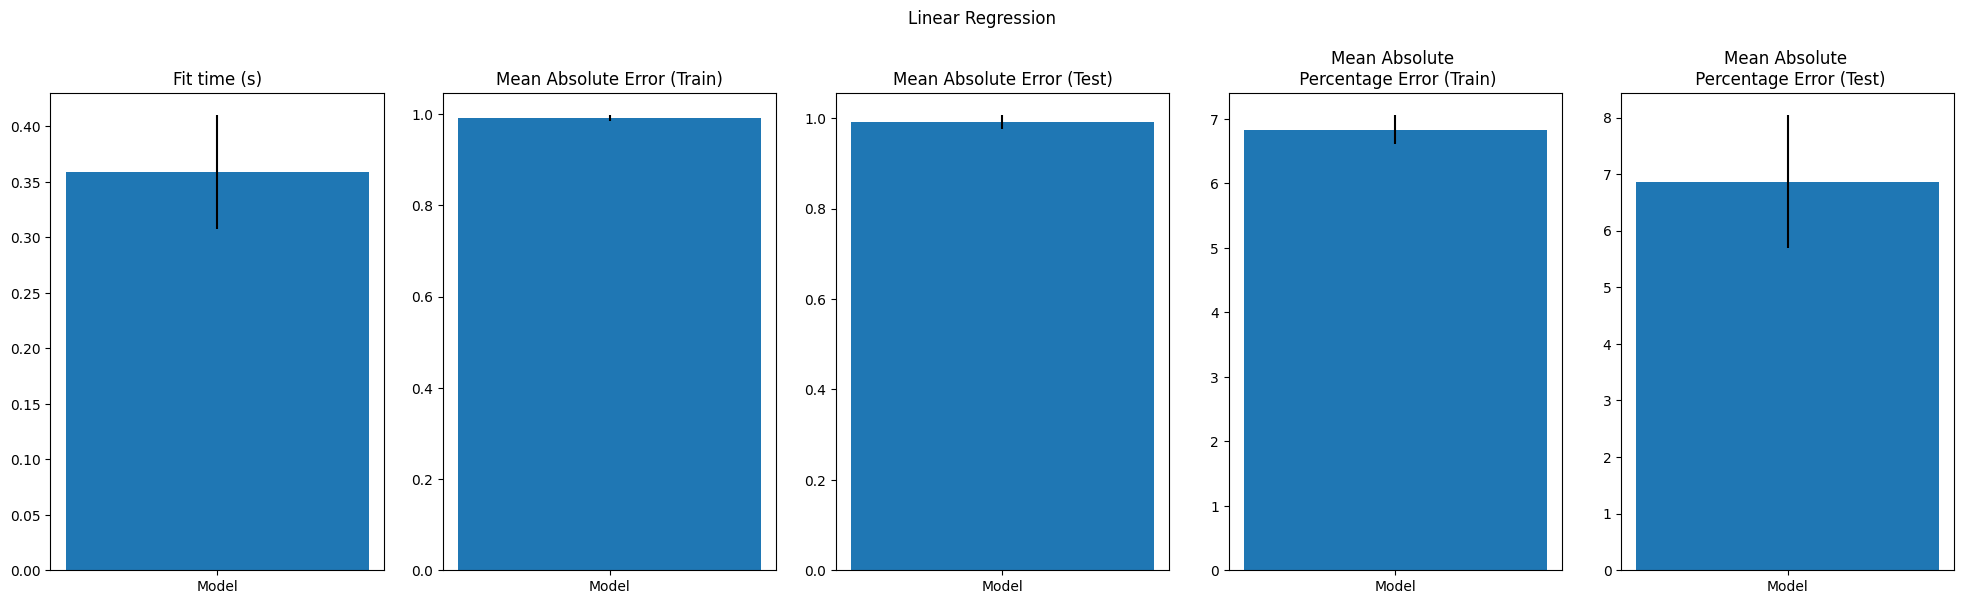

In [13]:
def plot_results(figure_title):
    fig, axes = plt.subplots(1, 5, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})

    plot_info = [
        ("fit_time", "Fit time (s)", axes[0], None),
        ("train_neg_mean_absolute_error", "Mean Absolute Error (Train)", axes[1], None),
        ("test_neg_mean_absolute_error", "Mean Absolute Error (Test)", axes[2], None),
        ("train_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Train)", axes[3], None),
        ("test_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Test)", axes[4], None)
    ]

    x, width = np.arange(1), 0.3
    for key, title, ax, y_limit in plot_info:
        item = model_result[key]

        cv_mean = np.mean(np.abs(item))
        cv_std = np.std(item)

        ax.bar(
            x=x,
            height=cv_mean,
            width=width,
            yerr=cv_std,
            color="C0",
        )
        ax.set(
            title=title,
            xticks=x,
            xticklabels=["Model"],
            ylim=y_limit,
        )

    # Adjust layout and spacing
    plt.tight_layout(pad=2.0)
    fig.suptitle(figure_title, y=1.02)  # Adjust the vertical position of the title

plot_results("Linear Regression")
#plt.show()

for key in model_result:
  item = model_result[key]
  cv_mean = np.mean(np.abs(item))
  cv_std = np.std(item)
  print(f'{key}: {cv_mean}')

# XGBoost

**Model**

In [ ]:
import xgboost as xgb
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

# selection of columns based on data types
numerical_columns_selector = make_column_selector(dtype_exclude=object)
categorical_columns_selector = make_column_selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

# one-hot encoding is applied to categorical columns, and numerical features
# are standardized
categorical_preprocessor = OneHotEncoder()
numerical_preprocessor = StandardScaler()

# use a transformer to concatenate the new columns
preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
        ("scale", numerical_preprocessor, numerical_columns)
    ]
)

xgboost_reg_model = make_pipeline(preprocessor, xgb.XGBRegressor(booster='gblinear'))

scoring = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error", "r2"]
n_cv_folds = 5
model_result = cross_validate(xgboost_reg_model, X, y, cv = n_cv_folds, scoring=scoring, return_train_score=True)
y_pred = cross_val_predict(xgboost_reg_model, X, y, cv=n_cv_folds)

**Prediction Visualization**

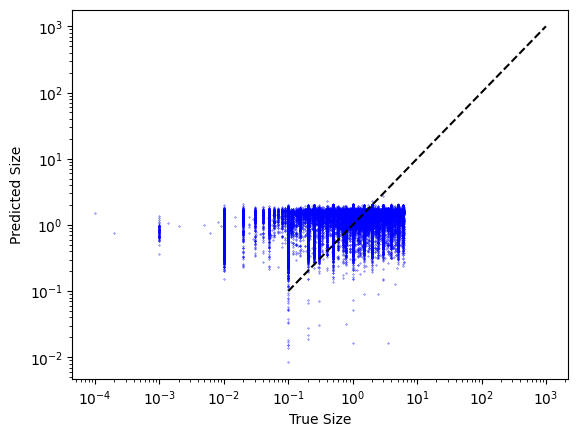

In [ ]:
plt.scatter(y, y_pred, s=0.3, marker='.', c='b')
plt.xlabel('True Size')
plt.ylabel('Predicted Size')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.plot([.1,20,1000],[.1,20,1000],c='k',linestyle='--')
plt.show()

**Error Visualization**

In [ ]:
def plot_results(figure_title):
    fig, axes = plt.subplots(1, 5, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})

    plot_info = [
        ("fit_time", "Fit time (s)", axes[0], None),
        ("train_neg_mean_absolute_error", "Mean Absolute Error (Train)", axes[1], None),
        ("test_neg_mean_absolute_error", "Mean Absolute Error (Test)", axes[2], None),
        ("train_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Train)", axes[3], None),
        ("test_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Test)", axes[4], None)
    ]

    x, width = np.arange(1), 0.3
    for key, title, ax, y_limit in plot_info:
        item = model_result[key]

        cv_mean = np.mean(np.abs(item))
        cv_std = np.std(item)

        ax.bar(
            x=x,
            height=cv_mean,
            width=width,
            yerr=cv_std,
            color="C0",
        )
        ax.set(
            title=title,
            xticks=x,
            xticklabels=["Model"],
            ylim=y_limit,
        )

    # Adjust layout and spacing
    plt.tight_layout(pad=2.0)
    fig.suptitle(figure_title, y=1.02)  # Adjust the vertical position of the title

plot_results("XGBoost Regressor")
#plt.show()

for key in model_result:
  item = model_result[key]

  cv_mean = np.mean(np.abs(item))
  cv_std = np.std(item)
  print(f'{key}: {cv_mean}')


**Error Visualization Using Cross-Validation with Hyperparameter Tuning**


In [ ]:
for parameter in xgboost_reg_model.get_params():
     print(parameter)

In [ ]:
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import GridSearchCV

param_grid = {
    "xgbregressor__learning_rate": (0, 0.10, 0.3),
    "xgbregressor__n_estimators": (50, 100),
    "xgbregressor__reg_alpha": (0, 1, 3),
    "xgbregressor__reg_lambda": (0, 0.01, 0.25),
    "xgbregressor__booster":['gblinear'],
}

scoring_param = "neg_mean_absolute_error"
scoring_model = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error"]

model_grid_search = GridSearchCV(xgboost_reg_model, param_grid=param_grid, scoring=scoring_param, n_jobs=2, cv=4)
model_grid_search.fit(X, y)
cv_results = cross_validate(
    model_grid_search, X, y, cv=5, n_jobs=2, return_train_score=True, return_estimator=True, scoring=scoring_model
)

def plot_results(figure_title):
    fig, axes = plt.subplots(1, 5, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})

    plot_info = [
        ("fit_time", "Fit time (s)", axes[0], None),
        ("train_neg_mean_absolute_error", "Mean Absolute Error (Train)", axes[1], None),
        ("test_neg_mean_absolute_error", "Mean Absolute Error (Test)", axes[2], None),
        ("train_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Train)", axes[3], None),
        ("test_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Test)", axes[4], None)
    ]

    x, width = np.arange(1), 0.3
    for key, title, ax, y_limit in plot_info:
        item = cv_results[key]

        cv_mean = np.mean(np.abs(item))
        cv_std = np.std(item)

        ax.bar(
            x=x,
            height=cv_mean,
            width=width,
            yerr=cv_std,
            color="C0",
        )
        ax.set(
            title=title,
            xticks=x,
            xticklabels=["Model"],
            ylim=y_limit,
        )

    # Adjust layout and spacing
    plt.tight_layout(pad=2.0)
    fig.suptitle(figure_title, y=1.02)  # Adjust the vertical position of the title

plot_results("XGBoost Regressor with Hyperparameter Tuning")

for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

for key in ["test_neg_mean_absolute_error", "train_neg_mean_absolute_error",
            "test_neg_mean_absolute_percentage_error", "train_neg_mean_absolute_percentage_error"]:

  item = cv_results[key]

  cv_mean = np.mean(np.abs(item))
  #cv_std = np.std(item)
  print(f'{key}: {cv_mean}')